In [ ]:
%cd /home

/home


# Settings

In [ ]:
num_epoch = 5
batch_size = 3
eval_ratio = 0.2
inference_file = 'ExtA0001.nii.gz'
alpha_vis = 0.3
max_img_size = 600 * 600 * 400

In [ ]:
ane_x, ane_y, ane_z = (177, 257, 334)

In [ ]:
angle = None  # angle of rotation for inference, choose 'None' for random value

# Downloads

In [ ]:
!pip install medpy PyYAML==5.4.1 pillow colorlog tensorboardX

     |████████████████████████████████| 151 kB 5.1 MB/s 
     |████████████████████████████████| 636 kB 48.6 MB/s 
     |████████████████████████████████| 124 kB 50.8 MB/s 
     |████████████████████████████████| 48.4 MB 58 kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754471 sha256=670886d833e7b928e47bf2d935d2e997b90a1c37fe147fbdbdf0a14dbf563824
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 149.9 MB 38 kB/s 
     |████████████████████████████████| 57 kB 2.5 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.278 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


# Import libraries

In [ ]:
import os
from pathlib import Path
from google.colab import drive
import shutil
import zipfile
import gzip
import csv
import json
import yaml

In [ ]:
import time
from datetime import datetime
import numpy as np
import pandas as pd
import random
import scipy.ndimage
import skimage.transform
import nibabel as nib
import SimpleITK as sitk
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [ ]:
import torch
import torchvision
import tensorboardX
# import torch_xla
# import torch_xla.core.xla_model as xm

In [ ]:
import os
if 'COLAB_TPU_ADDR' in os.environ:
    print(os.environ['COLAB_TPU_ADDR'])
# assert 'COLAB_TPU_ADDR' in os.environ

In [ ]:
# xm.get_xla_supported_devices()

In [ ]:
#for xla_device in xm.get_xla_supported_devices():
#    print(f"{xla_device}: {xm.get_memory_info(xla_device)}")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
sitk.__version__

'2.1.0'

In [ ]:
torch.__version__

'1.9.0+cu102'

In [ ]:
%matplotlib inline

# Create file system environment for the dataset


## Download dataset and GLIA-Net project from Google Drive



Mount Drive in order to retain files between sessions



In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


### Create paths

In [ ]:
drive_GLIA_Net_path = Path("/gdrive/MyDrive/Poli/Poli 2021/TCC2/GLIA-Net")
if not drive_GLIA_Net_path.exists():
    raise FileNotFoundError(f"{drive_GLIA_Net_path.as_posix()} not found!")

In [ ]:
drive_project_path = Path("/gdrive/MyDrive/Poli/Poli 2021/TCC2/CTA_dataset")
if not drive_project_path.exists():
    raise FileNotFoundError(f"{drive_project_path.as_posix()} not found!")

In [ ]:
drive_image_path = drive_project_path / "cta_img"
if not drive_image_path.exists():
    raise FileNotFoundError(f"{drive_image_path.as_posix()} not found!")

In [ ]:
drive_annotation_path = drive_project_path / "annotation"
if not drive_annotation_path.exists():
    raise FileNotFoundError(f"{drive_annotation_path.as_posix()} not found!")

In [ ]:
home_path = Path('/home')
if not home_path.exists():
    raise FileNotFoundError(f"{home_path.as_posix()} not found!")

In [ ]:
project_path = home_path / 'GLIA-Net'
if project_path.exists():
    raise FileExistsError(f"{project_path.as_posix()} already exists!")

In [ ]:
dataset_path = project_path / 'medical_data'
if dataset_path.exists():
    raise FileExistsError(f"{dataset_path.as_posix()} already exists!")

In [ ]:
dataset_image_path = dataset_path / 'cta_img'
if dataset_image_path.exists():
    raise FileExistsError(f"{dataset_image_path.as_posix()} already exists!")

In [ ]:
dataset_annotation_path = dataset_path / 'ane_seg'
if dataset_annotation_path.exists():
    raise FileExistsError(f"{dataset_annotation_path.as_posix()} already exists!")

In [ ]:
config_path = project_path / 'configs'
if config_path.exists():
    raise FileExistsError(f"{config_path.as_posix()} already exists!")

In [ ]:
log_ckpt_path = project_path / 'exp' / 'GLIA-Net' / '1'
if log_ckpt_path.exists():
    raise FileExistsError(f"{log_ckpt_path.as_posix()} already exists!")

In [ ]:
log_ckpt_drive_path = Path("/gdrive/MyDrive/Poli/Poli 2021/TCC2/GLIA_Net_CTA_result")
if log_ckpt_drive_path.exists():
    raise FileNotFoundError(f"{log_ckpt_drive_path.as_posix()} already exists!")

In [ ]:
ane_seg_csv_path = dataset_path / 'aneurysm_seg.csv'
if ane_seg_csv_path.exists():
    raise FileExistsError(f"{ane_seg_csv_path.as_posix()} already exists!")

In [ ]:
ane_seg_csv_drive_path = log_ckpt_drive_path / 'aneurysm_seg.csv'
if ane_seg_csv_drive_path.exists():
    raise FileExistsError(f"{ane_seg_csv_drive_path.as_posix()} already exists!")

## Copy GLIA-Net project

In [ ]:
project_path

PosixPath('/home/GLIA-Net')

In [ ]:
shutil.copytree(drive_GLIA_Net_path, project_path)

PosixPath('/home/GLIA-Net')

In [ ]:
%cd /home/GLIA-Net
!ls

/home/GLIA-Net
artworks	evaluate_per_case.py  medical_data	      train.py
configs		evaluate.py	      model		      transfer_model.py
core.py		exp		      readme.md		      utils
data_loader.py	inference.py	      refine_segmentation.py


## Copy dataset

In [ ]:
shutil.copytree(drive_image_path, dataset_image_path)

PosixPath('/home/GLIA-Net/medical_data/cta_img')

In [ ]:
shutil.copytree(drive_annotation_path , dataset_annotation_path)

PosixPath('/home/GLIA-Net/medical_data/ane_seg')

### Verify download

In [ ]:
def print_tree(path):
    if isinstance(path, str):
        _path = Path(path)
    elif isinstance(path, Path):
        _path = path
    else:
        raise TypeError(f'path must be a string or a pathlib.Path object, got {type(path)}')
    if _path.exists():
        print(_path.as_posix())
        if _path.is_dir():
            for subpath in _path.glob('*'):
                print_tree(subpath)
    else:
        raise FileNotFoundError(f"{_path.as_posix()} not found!")

In [ ]:
print_tree(dataset_image_path)

/home/GLIA-Net/medical_data/cta_img
/home/GLIA-Net/medical_data/cta_img/ExtB0046.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0015.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtA0007.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0059.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtA0065.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0024.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtA0016.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0004.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0019.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0029.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtA0013.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0023.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0054.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtA0050.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0066.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtA0041.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0026.nii.gz
/home/GLIA-Net/medical_data/cta_img/ExtB0034.nii.gz
/home/GLIA-Net/medical_data/

In [ ]:
print_tree(dataset_annotation_path)

/home/GLIA-Net/medical_data/ane_seg
/home/GLIA-Net/medical_data/ane_seg/ExtB0046.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0015.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtA0007.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0059.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtA0065.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0024.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtA0016.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0004.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0019.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0029.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtA0013.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0023.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0054.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtA0050.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0066.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtA0041.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0026.nii.gz
/home/GLIA-Net/medical_data/ane_seg/ExtB0034.nii.gz
/home/GLIA-Net/medical_data/

## Structure external dataset A and B

In [ ]:
def generate_aneurysm_segmentation_dataset_file(path, verbose=1, eval_ratio=0.2):

    img_reader = sitk.ImageFileReader()
    img_reader.SetImageIO('NiftiImageIO')

    n_cta = sum(1 for file in (path / 'cta_img').glob('*'))
    n_seg = sum(1 for file in (path / 'ane_seg').glob('*'))

    # write header
    with open(path / 'aneurysm_seg.csv', 'w', newline='') as config_dataset_csv:
        csv_writer = csv.writer(config_dataset_csv)
        csv_writer.writerow(["subset", "id", "hospital", "cta_img_file", "aneurysm_seg_file"])

    for path_i, cta_path in enumerate((path / 'cta_img').glob('*'), 1):

        seg_path = path / 'ane_seg' / cta_path.name
        if not seg_path.exists():
            raise FileNotFoundError(f'Segmentation mask of CTA image {cta_path.as_posix()} not found at {seg_path.as_posix()} !')

        img_reader.SetFileName(seg_path.as_posix())
        img_itk = img_reader.Execute()

        if img_itk.GetNumberOfPixels() > max_img_size:
            print('Too big! ---> ', cta_path.name, img_itk.GetSize(), img_itk.GetNumberOfPixels())
            continue
        
        with open(path / 'aneurysm_seg.csv', 'a', newline='') as config_dataset_csv:
            csv_writer = csv.writer(config_dataset_csv)
            csv_writer.writerow([
                                 'train' if random.random() > eval_ratio else 'eval',
                                 'P' + str(path_i).zfill(3),
                                 'hos_' + ('1' if 'A' in cta_path.stem else '2'),
                                 cta_path.parent.name + '/' + cta_path.name,
                                 seg_path.parent.name + '/' + seg_path.name,
                                 ])

In [ ]:
generate_aneurysm_segmentation_dataset_file(dataset_path, eval_ratio=eval_ratio)
dataset_info_df = pd.read_csv(dataset_path / 'aneurysm_seg.csv')
if len(dataset_info_df[dataset_info_df['cta_img_file'] == '' + inference_file]) > 0:
    if dataset_info_df[dataset_info_df['cta_img_file'] == '' + inference_file]['subset'] == 'train':
        generate_aneurysm_segmentation_dataset_file(dataset_path, eval_ratio=0.3)
        dataset_info_df = pd.read_csv(dataset_path / 'aneurysm_seg.csv')

Too big! --->  ExtB0046.nii.gz (465, 465, 770) 166493250
Too big! --->  ExtA0007.nii.gz (506, 506, 761) 194843396
Too big! --->  ExtA0065.nii.gz (700, 700, 665) 325850000
Too big! --->  ExtB0024.nii.gz (467, 467, 810) 176652090
Too big! --->  ExtA0016.nii.gz (512, 512, 665) 174325760
Too big! --->  ExtB0004.nii.gz (476, 476, 695) 157470320
Too big! --->  ExtB0019.nii.gz (610, 610, 1140) 424194000
Too big! --->  ExtB0029.nii.gz (555, 555, 770) 237179250
Too big! --->  ExtA0013.nii.gz (502, 502, 1131) 285016524
Too big! --->  ExtB0023.nii.gz (472, 472, 750) 167088000
Too big! --->  ExtB0054.nii.gz (467, 467, 819) 178614891
Too big! --->  ExtA0050.nii.gz (551, 551, 561) 170320161
Too big! --->  ExtB0066.nii.gz (552, 552, 1117) 340354368
Too big! --->  ExtA0041.nii.gz (748, 748, 665) 372070160
Too big! --->  ExtB0026.nii.gz (520, 520, 715) 193336000
Too big! --->  ExtB0034.nii.gz (520, 520, 810) 219024000
Too big! --->  ExtA0047.nii.gz (512, 512, 665) 174325760
Too big! --->  ExtA0021.nii.

In [ ]:
dataset_info_df[dataset_info_df['cta_img_file'] == 'cta_img/' + inference_file]

,subset,id,hospital,cta_img_file,aneurysm_seg_file


In [ ]:
!cat /home/GLIA-Net/medical_data/aneurysm_seg.csv

subset,id,hospital,cta_img_file,aneurysm_seg_file
train,P002,hos_2,cta_img/ExtB0015.nii.gz,ane_seg/ExtB0015.nii.gz
train,P004,hos_2,cta_img/ExtB0059.nii.gz,ane_seg/ExtB0059.nii.gz
train,P022,hos_2,cta_img/ExtB0011.nii.gz,ane_seg/ExtB0011.nii.gz
train,P026,hos_2,cta_img/ExtB0041.nii.gz,ane_seg/ExtB0041.nii.gz
train,P028,hos_2,cta_img/ExtB0003.nii.gz,ane_seg/ExtB0003.nii.gz
train,P032,hos_1,cta_img/ExtA0061.nii.gz,ane_seg/ExtA0061.nii.gz
train,P034,hos_1,cta_img/ExtA0030.nii.gz,ane_seg/ExtA0030.nii.gz
train,P035,hos_2,cta_img/ExtB0008.nii.gz,ane_seg/ExtB0008.nii.gz
train,P036,hos_1,cta_img/ExtA0059.nii.gz,ane_seg/ExtA0059.nii.gz
train,P042,hos_2,cta_img/ExtB0017.nii.gz,ane_seg/ExtB0017.nii.gz
eval,P043,hos_2,cta_img/ExtB0061.nii.gz,ane_seg/ExtB0061.nii.gz
eval,P048,hos_2,cta_img/ExtB0001.nii.gz,ane_seg/ExtB0001.nii.gz
train,P050,hos_2,cta_img/ExtB0013.nii.gz,ane_seg/ExtB0013.nii.gz
train,P055,hos_2,cta_img/ExtB0064.nii.gz,ane_seg/ExtB0064.nii.gz
train,P058,hos_2,cta_img/ExtB0025.nii.gz,a

In [ ]:
len(dataset_info_df)

35

In [ ]:
dataset_info_df.tail(10)

,subset,id,hospital,cta_img_file,aneurysm_seg_file
25,eval,P095,hos_2,cta_img/ExtB0038.nii.gz,ane_seg/ExtB0038.nii.gz
26,train,P104,hos_1,cta_img/ExtA0012.nii.gz,ane_seg/ExtA0012.nii.gz
27,eval,P113,hos_2,cta_img/ExtB0018.nii.gz,ane_seg/ExtB0018.nii.gz
28,train,P114,hos_2,cta_img/ExtB0062.nii.gz,ane_seg/ExtB0062.nii.gz
29,train,P120,hos_2,cta_img/ExtB0056.nii.gz,ane_seg/ExtB0056.nii.gz
30,train,P124,hos_2,cta_img/ExtB0033.nii.gz,ane_seg/ExtB0033.nii.gz
31,eval,P131,hos_2,cta_img/ExtB0036.nii.gz,ane_seg/ExtB0036.nii.gz
32,train,P136,hos_2,cta_img/ExtB0021.nii.gz,ane_seg/ExtB0021.nii.gz
33,train,P137,hos_2,cta_img/ExtB0043.nii.gz,ane_seg/ExtB0043.nii.gz
34,train,P138,hos_1,cta_img/ExtA0060.nii.gz,ane_seg/ExtA0060.nii.gz


In [ ]:
print(f"Number of train images: {len(dataset_info_df[dataset_info_df['subset'] == 'train'])}")

Number of train images: 28


In [ ]:
print(f"Number of eval images: {len(dataset_info_df[dataset_info_df['subset'] == 'eval'])}")

Number of eval images: 7


In [ ]:
def update_config_file(path):
    
    with open(path, 'r') as fr:
        data = yaml.safe_load(fr)
    
    if 'data' in data.keys():
        if 'normalization' in data['data'].keys():
            data['data']['normalization'] = 'hu_norm'
        if 'features' in data['data'].keys():
            data['data']['features'] = {'cta_img_file': 'image'}
        if 'model' in data.keys():
            if 'in_channels' in data['model'].keys():
                data['model']['in_channels'] = 3
        if 'train' in data.keys():
            if 'num_epoch' in data['train'].keys():
                data['train']['num_epoch'] = 3 + num_epoch
            if 'batch_size' in data['train'].keys():
                data['train']['batch_size'] = batch_size
    if 'ckpt_file' in data:
        data['ckpt_file'] = 'checkpoint-0245700.pt'
    
    with open(path, 'w') as fw:
        yaml.safe_dump(data, fw, sort_keys=False)

In [ ]:
for path in config_path.glob('*.yaml'):
    print(path.name)
    update_config_file(path)

inference_GLIA-Net.yaml
transfer_GLIA-Net.yaml
eval_per_case.yaml
eval_GLIA-Net.yaml
GLIA-Net.yaml


In [ ]:
!cat ./configs/*.yaml

task: AneurysmSeg
logging_folder: logs
ckpt_folder: ckpt
summary_folder: summary
load_best_model: false
ckpt_file: checkpoint-0245700.pt
log_every_n_iters: 10
model:
  filename: GLIA-Net
  classname: GLIANet
  with_global: true
  global_type: attention_map
  global_out_channels: 2
  in_channels: 3
  out_channels: 2
  num_classes: 2
  f_maps:
  - 16
  - 32
  - 64
  - 128
  norm_type: gn
data:
  features:
    cta_img_file: image
  labels:
    aneurysm_seg_file: mask
  normalization: hu_norm
  hu_values:
  - - 0
    - 100
  - - 100
    - 200
  - - 200
    - 800
  data_root:
    windows: medical_data\
    linux: medical_data/
  instance_list_file: aneurysm_seg.csv
  eval_num_file: 0
  eval_pos_neg_ratio:
  - 1
  - 1
  img_spacing: null
  patch_size:
  - 96
  - 96
  - 96
  overlap_step:
  - 48
  - 48
  - 48
  num_io_workers: 1
  num_proc_workers: 0
train:
  manual_seed: 12345
  batch_size: 3
  log_summary_every_n_iters: 20
  losses:
  - name: ExpLoss
    loss_weight: 1.0
    final_activatio

In [ ]:
!cat configs/inference*

task: AneurysmSeg
logging_folder: logs
ckpt_folder: ckpt
summary_folder: summary
load_best_model: false
ckpt_file: checkpoint-0245700.pt
model:
  filename: GLIA-Net
  classname: GLIANet
  with_global: true
  global_type: attention_map
  global_out_channels: 2
  in_channels: 3
  out_channels: 2
  num_classes: 2
  f_maps:
  - 16
  - 32
  - 64
  - 128
  norm_type: gn
data:
  features:
    cta_img_file: image
  normalization: hu_norm
  hu_values:
  - - 0
    - 100
  - - 100
    - 200
  - - 200
    - 800
  img_spacing: null
  patch_size:
  - 96
  - 96
  - 96
  overlap_step:
  - 48
  - 48
  - 48
  num_proc_workers: 3
train:
  batch_size: 3
  losses:
  - name: ExpLoss
    final_activation: softmax
  - name: SoftmaxCrossEntropyLoss
    final_activation: softmax
eval:
  phase: inference
  probability_threshold: 0.5


# GLIA-Net aneurysm segmentation

In [ ]:
!pwd
!ls

/home/GLIA-Net
artworks	evaluate_per_case.py  medical_data	      train.py
configs		evaluate.py	      model		      transfer_model.py
core.py		exp		      readme.md		      utils
data_loader.py	inference.py	      refine_segmentation.py


In [ ]:
if torch.cuda.is_available():
    for device_i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_properties(device_i))

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


## Generated rotated image

In [ ]:
def get_rotation_matrix_3d(direction, angle):
    """
    Get Rotation Matrix in 3D.

    Parameters
    ----------
    direction: tuple
        3d vector with the direction of the rotation
    angle: float
        angle of rotation in rad
    
    Returns
    -------
    rotation_matrix: np.ndarray
    """
    ux, uy, uz = direction
    if ux*ux + uy*uy + uz*uz != 1:
        sqrt_mod = ux*ux + uy*uy + uz*uz
        ux = ux / sqrt_mod
        uy = uy / sqrt_mod
        uz = uz / sqrt_mod
    c = np.cos(angle)
    s = np.sin(angle)

    rotation_matrix = np.empty((3, 3), np.float32)
    rotation_matrix[0][0] = c + ux * ux * (1 - c)
    rotation_matrix[0][1] = ux * uy * (1 - c) - uz * s
    rotation_matrix[0][2] = ux * uz * (1 - c) + uy * s
    rotation_matrix[1][0] = ux * uy * (1 - c) + uz * s
    rotation_matrix[1][1] = c + uy * uy * (1 - c)
    rotation_matrix[1][2] = uy * uz * (1 - c) - ux * s
    rotation_matrix[2][0] = ux * uz * (1 - c) - uy * s
    rotation_matrix[2][1] = uy * uz * (1 - c) + ux * s
    rotation_matrix[2][2] = c + uz * uz * (1 - c)

    return rotation_matrix

In [ ]:
def get_center_3d(img):

    center = img.TransformIndexToPhysicalPoint(tuple([(ci + 1) // 2 for ci in img.GetSize()]))

    return center

In [ ]:
def resample(img, transform):
    
    ref_img = img
    interpolator = sitk.sitkLinear
    default_value = int(np.min(sitk.GetArrayFromImage(img)))
    
    return sitk.Resample(img, ref_img, transform, interpolator, default_value)

In [ ]:
def rotate_3d(img, angle):

    euler_transform = sitk.Euler3DTransform()
    
    center = get_center_3d(img)
    euler_transform.SetCenter(center)

    euler_transform.SetRotation(*angle)

    rot_img = resample(img, euler_transform)
    
    return rot_img

In [ ]:
if angle is None:
    angle = 2*np.pi * np.random.rand()
angle

0.7337697963103537

## Inference

### Visualize input image

In [ ]:
# read input image
img_reader = sitk.ImageFileReader()
img_reader.SetImageIO('NiftiImageIO')
img_reader.SetFileName('/home/GLIA-Net/medical_data/cta_img/' + inference_file)
input_img_itk = img_reader.Execute()

print('Class                :', type(input_img_itk))
print('Number of dimensions :', input_img_itk.GetDimension())
print('Size                 :', input_img_itk.GetSize())
print('Number of channels   :', input_img_itk.GetNumberOfComponentsPerPixel())
print('Number of voxels     :', input_img_itk.GetNumberOfPixels())

Class                : <class 'SimpleITK.SimpleITK.Image'>
Number of dimensions : 3
Size                 : (586, 586, 529)
Number of channels   : 1
Number of voxels     : 181656484


In [ ]:
input_rot_img_itk = rotate_3d(input_img_itk, (0, 0, angle))

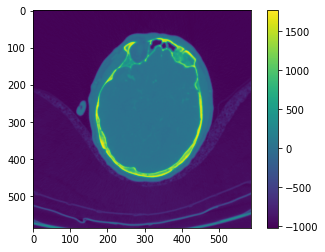

In [ ]:
input_img_np = sitk.GetArrayViewFromImage(input_img_itk)
plt.imshow(input_img_np[ane_z,:,:])
plt.colorbar()

In [ ]:
input_rot_img_np = sitk.GetArrayViewFromImage(input_rot_img_itk)
plt.imshow(input_rot_img_np[ane_z,:,:])
plt.colorbar()

In [ ]:
img_writer = sitk.ImageFileWriter()
img_writer.SetFileName('/home/GLIA-Net/medical_data/cta_img/' + 'rot_' + inference_file)
img_writer.Execute(input_rot_img_itk)

### Predict aneurysm mask

In [ ]:
!python inference.py \
    -c inference_GLIA-Net \
    -i /home/GLIA-Net/medical_data/cta_img/$inference_file \
    -t nii \
    -d 0 \
    -o /tmp

2021-08-22 05:45:02 [MainThread] INFO [TaskAneurysmSegInferencer] - use device 0
2021-08-22 05:45:09 [MainThread] INFO [TaskAneurysmSegInferencer] - Checkpoint 'exp/GLIA-Net/1/ckpt/checkpoint-0245700.pt' loaded
2021-08-22 05:45:09 [MainThread] INFO [TaskAneurysmSegInferencer] - Begin to scan input_folder_or_file ['/home/GLIA-Net/medical_data/cta_img/ExtA0001.nii.gz']...
('/home/GLIA-Net/medical_data/cta_img/ExtA0001.nii.gz',)
2021-08-22 05:45:14 [MainThread] INFO [TaskAneurysmSegInferencer] - inference instance ExtA0001.nii.gz (1584 patches)...
	processing procedure: 100.0%
	summarize and save...
	((total time: 116.94; preprocess_time: 0.72; loading_time: 8.83; network time: 106.06; summarize_time: 1.03) Prediction of instance ExtA0001.nii.gz saved to /tmp/ExtA0001.nii.gz. 
2021-08-22 05:47:15 [MainThread] INFO [TaskAneurysmSegInferencer] - finish 1 in 1 instances


In [ ]:
!python inference.py \
    -c inference_GLIA-Net \
    -i /home/GLIA-Net/medical_data/cta_img/rot_$inference_file \
    -t nii \
    -d 0 \
    -o /tmp

2021-08-22 05:47:19 [MainThread] INFO [TaskAneurysmSegInferencer] - use device 0
2021-08-22 05:47:21 [MainThread] INFO [TaskAneurysmSegInferencer] - Checkpoint 'exp/GLIA-Net/1/ckpt/checkpoint-0245700.pt' loaded
2021-08-22 05:47:21 [MainThread] INFO [TaskAneurysmSegInferencer] - Begin to scan input_folder_or_file ['/home/GLIA-Net/medical_data/cta_img/rot_ExtA0001.nii.gz']...
('/home/GLIA-Net/medical_data/cta_img/rot_ExtA0001.nii.gz',)
2021-08-22 05:47:25 [MainThread] INFO [TaskAneurysmSegInferencer] - inference instance rot_ExtA0001.nii.gz (1584 patches)...
	processing procedure: 100.0%
	summarize and save...
	((total time: 116.80; preprocess_time: 0.73; loading_time: 8.56; network time: 106.30; summarize_time: 1.03) Prediction of instance rot_ExtA0001.nii.gz saved to /tmp/rot_ExtA0001.nii.gz. 
2021-08-22 05:49:27 [MainThread] INFO [TaskAneurysmSegInferencer] - finish 1 in 1 instances


### Visualize predicted aneurysm mask

In [ ]:
!ls -l /tmp

total 1404
-rw-r--r-- 1 root root   1457 Aug 22 05:08 dap_multiplexer.f0493075dd2f.root.log.INFO.20210822-050838.77
lrwxrwxrwx 1 root root     61 Aug 22 05:08 dap_multiplexer.INFO -> dap_multiplexer.f0493075dd2f.root.log.INFO.20210822-050838.77
srwxr-xr-x 1 root root      0 Aug 22 05:08 debugger_atxfxt53t
srw------- 1 root root      0 Aug 22 05:28 drivefs_ipc.0
srw------- 1 root root      0 Aug 22 05:28 drivefs_ipc.0_shell
-rw-r--r-- 1 root root 707422 Aug 22 05:47 ExtA0001.nii.gz
drwx------ 2 root root   4096 Aug 22 05:08 initgoogle_syslog_dir.0
-rw-r--r-- 1 root root 709095 Aug 22 05:49 rot_ExtA0001.nii.gz
drwx------ 2 root root   4096 Aug 22 05:28 tmpohg3137u


In [ ]:
img_reader = sitk.ImageFileReader()
img_reader.SetImageIO('NiftiImageIO')
img_reader.SetFileName('/tmp/' + inference_file)
pred_img_itk = img_reader.Execute()

print('Class                :', type(pred_img_itk))
print('Number of dimensions :', pred_img_itk.GetDimension())
print('Size                 :', pred_img_itk.GetSize())
print('Number of channels   :', pred_img_itk.GetNumberOfComponentsPerPixel())
print('Number of voxels     :', pred_img_itk.GetNumberOfPixels())

Class                : <class 'SimpleITK.SimpleITK.Image'>
Number of dimensions : 3
Size                 : (586, 586, 529)
Number of channels   : 1
Number of voxels     : 181656484


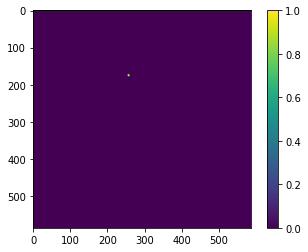

In [ ]:
pred_img_np = sitk.GetArrayViewFromImage(pred_img_itk)
plt.imshow(pred_img_np[ane_z,:,:])
plt.colorbar()

In [ ]:
img_reader = sitk.ImageFileReader()
img_reader.SetImageIO('NiftiImageIO')
img_reader.SetFileName('/tmp/rot_' + inference_file)
pred_rot_img_itk = img_reader.Execute()

print('Class                :', type(pred_rot_img_itk))
print('Number of dimensions :', pred_rot_img_itk.GetDimension())
print('Size                 :', pred_rot_img_itk.GetSize())
print('Number of channels   :', pred_rot_img_itk.GetNumberOfComponentsPerPixel())
print('Number of voxels     :', pred_rot_img_itk.GetNumberOfPixels())

Class                : <class 'SimpleITK.SimpleITK.Image'>
Number of dimensions : 3
Size                 : (586, 586, 529)
Number of channels   : 1
Number of voxels     : 181656484


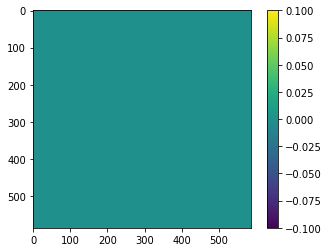

In [ ]:
pred_rot_img_np = sitk.GetArrayViewFromImage(pred_rot_img_itk)
plt.imshow(pred_rot_img_np[ane_z,:,:])
plt.colorbar()

### Visualize ground truth aneurysm mask

In [ ]:
img_reader = sitk.ImageFileReader()
img_reader.SetImageIO('NiftiImageIO')
img_reader.SetFileName('/home/GLIA-Net/medical_data/ane_seg/' + inference_file)
true_img_itk = img_reader.Execute()

print('Class                :', type(true_img_itk))
print('Number of dimensions :', true_img_itk.GetDimension())
print('Size                 :', true_img_itk.GetSize())
print('Number of channels   :', true_img_itk.GetNumberOfComponentsPerPixel())
print('Number of voxels     :', true_img_itk.GetNumberOfPixels())

Class                : <class 'SimpleITK.SimpleITK.Image'>
Number of dimensions : 3
Size                 : (586, 586, 529)
Number of channels   : 1
Number of voxels     : 181656484


In [ ]:
true_rot_img_itk = rotate_3d(true_img_itk, (0, 0, angle))

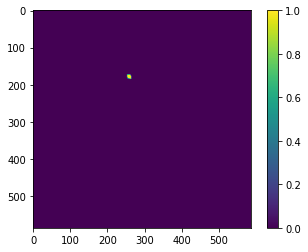

In [ ]:
true_img_np = sitk.GetArrayViewFromImage(true_img_itk)
plt.imshow(true_img_np[ane_z,:,:])
plt.colorbar()

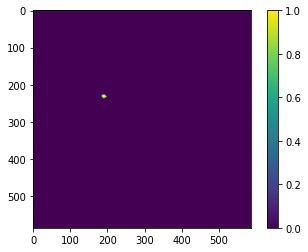

In [ ]:
true_rot_img_np = sitk.GetArrayViewFromImage(true_rot_img_itk)
plt.imshow(true_rot_img_np[ane_z,:,:])
plt.colorbar()

In [ ]:
img_writer = sitk.ImageFileWriter()
img_writer.SetFileName('/home/GLIA-Net/medical_data/ane_seg/' + 'rot_' + inference_file)
img_writer.Execute(true_rot_img_itk)

### Visualize exams annotated with ground truth and predicted masks

In [ ]:
input_img_shape = input_img_itk.GetSize()
if ane_x is None or ane_y is None or ane_z is None:
    ane_z, ane_y, ane_x = [ane // 2 for ane in input_img_shape]
if ane_x >= input_img_shape[2]:
    ane_x = input_img_shape[2] // 2
if ane_y >= input_img_shape[1]:
    ane_y = input_img_shape[1] // 2
if ane_z >= input_img_shape[0]:
    ane_z = input_img_shape[0] // 2

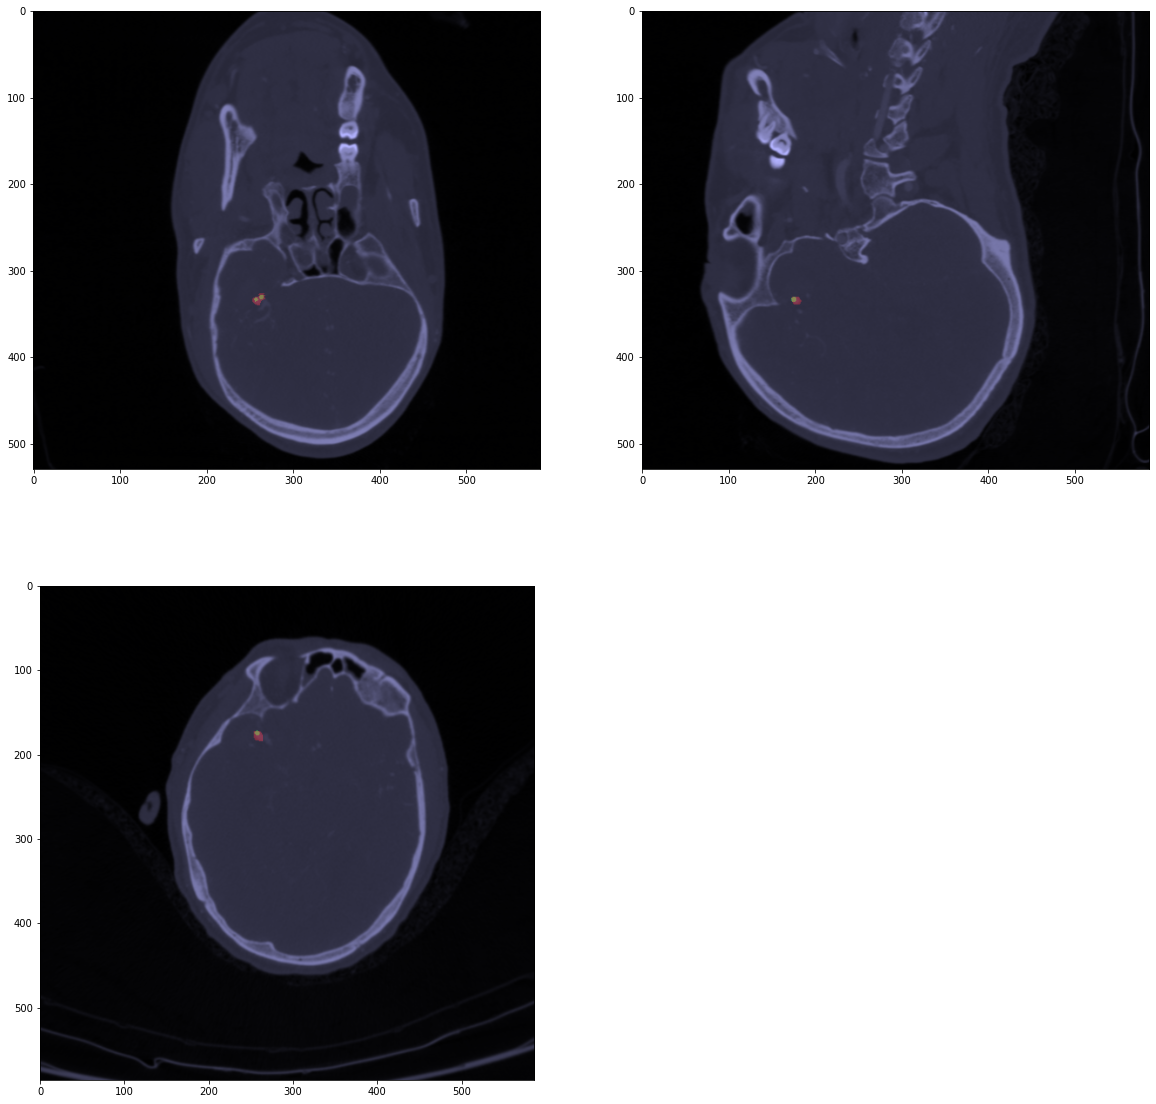

In [ ]:
input_res_img_np = np.stack([input_img_np, input_img_np, input_img_np], -1)
input_res_img_np = (input_res_img_np - np.min(input_res_img_np)) / (np.max(input_res_img_np) - np.min(input_res_img_np))
input_res_img_np[:,:,:,0:2] = (1 - alpha_vis) * input_res_img_np[:,:,:,0:2]

input_res_img_np[:,:,:,0] = input_res_img_np[:,:,:,0] + alpha_vis * true_img_np
input_res_img_np[:,:,:,1] = input_res_img_np[:,:,:,1] + alpha_vis * pred_img_np

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(input_res_img_np[:,ane_x,:,:])

plt.subplot(2, 2, 2)
plt.imshow(input_res_img_np[:,:,ane_y,:])

plt.subplot(2, 2, 3)
plt.imshow(input_res_img_np[ane_z,:,:,:])

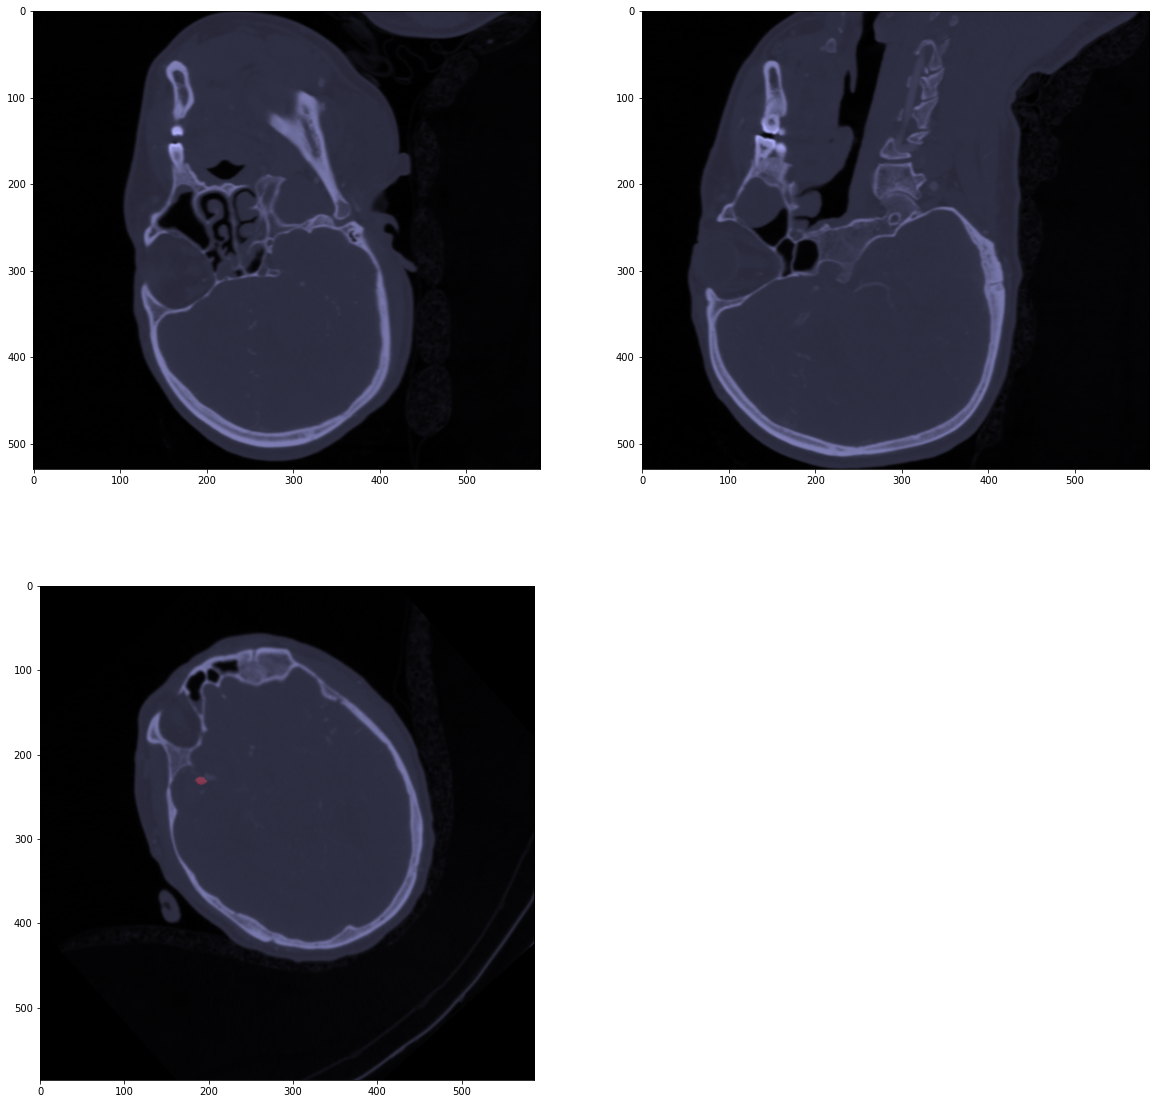

In [ ]:
input_rot_res_img_np = np.stack([input_rot_img_np, input_rot_img_np, input_rot_img_np], -1)
input_rot_res_img_np = (input_rot_res_img_np - np.min(input_rot_res_img_np)) / (np.max(input_rot_res_img_np) - np.min(input_rot_res_img_np))
input_rot_res_img_np[:,:,:,0:2] = (1 - alpha_vis) * input_rot_res_img_np[:,:,:,0:2]

input_rot_res_img_np[:,:,:,0] = input_rot_res_img_np[:,:,:,0] + alpha_vis * true_rot_img_np
input_rot_res_img_np[:,:,:,1] = input_rot_res_img_np[:,:,:,1] + alpha_vis * pred_rot_img_np

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(input_rot_res_img_np[:,ane_x,:,:])

plt.subplot(2, 2, 2)
plt.imshow(input_rot_res_img_np[:,:,ane_y,:])

plt.subplot(2, 2, 3)
plt.imshow(input_rot_res_img_np[ane_z,:,:,:])

## Evaluation

In [ ]:
!nvidia-smi

Sun Aug 22 05:50:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    36W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.memory_summary(0))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [ ]:
# !python evaluate_per_case.py \
#     -c eval_per_case \
#     -d 0 \
#     -g medical_data/ane_seg/ \
#     -p medical_data/ane_seg \
#     -l exp/eval_per_case

In [ ]:
!python evaluate.py -c eval_GLIA-Net \
    -d 0

2021-08-22 05:50:10 [MainThread] INFO [TaskAneurysmSegEvaler] - use device 0
2021-08-22 05:50:10 [MainThread] INFO [TaskAneurysmSegEvaler] - Seed the RNG for all devices with 12345
2021-08-22 05:50:10 [MainThread] INFO [TaskAneurysmSegEvaler] - The eval TaskListProducer will read 7 files with 1 workers for eval
2021-08-22 05:50:13 [MainThread] INFO [TaskAneurysmSegEvaler] - Checkpoint 'exp/GLIA-Net/1/ckpt/checkpoint-0245700.pt' loaded
2021-08-22 05:50:13 [MainThread] INFO [TaskAneurysmSegEvaler] - All layers are trainable
2021-08-22 05:50:13 [MainThread] INFO [TaskAneurysmSegEvaler] - test epoch 4...
2021-08-22 05:50:13 [MainThread] INFO [TaskAneurysmSegEvaler] - The eval TaskListProducer begins to read files in one epoch...
2021-08-22 05:50:44 [MainThread] INFO [TaskAneurysmSegEvaler] - (Time per iter: 3.10s)test iter 10. epoch 4/10. total_loss: 0.1732 local_loss: 0.1699 global_loss: 0.0033 ap: 0.7532 auc: 0.9966 precision: 0.9174 recall: 0.8057 dsc: 0.8580 hd95: 1.7387 per_target_pre

In [ ]:
print(torch.cuda.memory_summary(0))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [ ]:
print('Max memory allocated:', torch.cuda.max_memory_allocated(), 'bytes')
print('Max memory reserved: ', torch.cuda.max_memory_reserved(), 'bytes')

Max memory allocated: 0 bytes
Max memory reserved:  0 bytes


## Train

In [ ]:
!python train.py -c GLIA-Net -d 0

2021-08-22 06:10:51 [MainThread] INFO [TaskAneurysmSegTrainer] - use device 0
2021-08-22 06:10:51 [MainThread] INFO [TaskAneurysmSegTrainer] - The train TaskListProducer will read 28 files with 1 workers for train
2021-08-22 06:10:51 [MainThread] INFO [TaskAneurysmSegTrainer] - The eval TaskListProducer will read 7 files with 1 workers for eval
2021-08-22 06:10:54 [MainThread] INFO [TaskAneurysmSegTrainer] - Checkpoint 'exp/GLIA-Net/1/ckpt/checkpoint-0245700.pt' loaded
2021-08-22 06:10:54 [MainThread] INFO [TaskAneurysmSegTrainer] - All layers are trainable
2021-08-22 06:10:54 [MainThread] INFO [TaskAneurysmSegTrainer] - Train 5 epochs with batch size 3
2021-08-22 06:10:54 [MainThread] INFO [TaskAneurysmSegTrainer] - Begin to train on epoch 4/8...
2021-08-22 06:10:54 [MainThread] INFO [TaskAneurysmSegTrainer] - The train TaskListProducer begins to read files in one epoch...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `sche

## Inference

### Visualize input image

In [ ]:
# read input image
img_reader = sitk.ImageFileReader()
img_reader.SetImageIO('NiftiImageIO')
img_reader.SetFileName('/home/GLIA-Net/medical_data/cta_img/' + inference_file)
input_img_itk = img_reader.Execute()

print('Class                :', type(input_img_itk))
print('Number of dimensions :', input_img_itk.GetDimension())
print('Size                 :', input_img_itk.GetSize())
print('Number of channels   :', input_img_itk.GetNumberOfComponentsPerPixel())
print('Number of voxels     :', input_img_itk.GetNumberOfPixels())

Class                : <class 'SimpleITK.SimpleITK.Image'>
Number of dimensions : 3
Size                 : (586, 586, 529)
Number of channels   : 1
Number of voxels     : 181656484


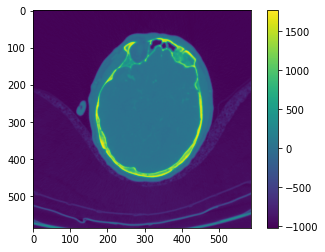

In [ ]:
input_img_np = sitk.GetArrayViewFromImage(input_img_itk)
plt.imshow(input_img_np[ane_z,:,:])
plt.colorbar()

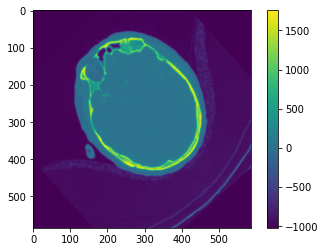

In [ ]:
input_rot_img_np = sitk.GetArrayViewFromImage(input_rot_img_itk)
plt.imshow(input_rot_img_np[ane_z,:,:])
plt.colorbar()

### Predict aneurysm mask

In [ ]:
!python inference.py \
    -c inference_GLIA-Net \
    -i /home/GLIA-Net/medical_data/cta_img/$inference_file \
    -t nii \
    -d 0 \
    -o /tmp

2021-08-22 06:13:52 [MainThread] INFO [TaskAneurysmSegInferencer] - use device 0
2021-08-22 06:13:58 [MainThread] INFO [TaskAneurysmSegInferencer] - Checkpoint 'exp/GLIA-Net/1/ckpt/checkpoint-0245700.pt' loaded
2021-08-22 06:13:58 [MainThread] INFO [TaskAneurysmSegInferencer] - Begin to scan input_folder_or_file ['/home/GLIA-Net/medical_data/cta_img/ExtA0001.nii.gz']...
('/home/GLIA-Net/medical_data/cta_img/ExtA0001.nii.gz',)
2021-08-22 06:14:02 [MainThread] INFO [TaskAneurysmSegInferencer] - inference instance ExtA0001.nii.gz (1584 patches)...
	processing procedure: 38.1%

In [ ]:
!python inference.py \
    -c inference_GLIA-Net \
    -i /home/GLIA-Net/medical_data/cta_img/rot_$inference_file \
    -t nii \
    -d 0 \
    -o /tmp

### Visualize predicted aneurysm mask

In [ ]:
!ls -l /tmp

In [ ]:
img_reader = sitk.ImageFileReader()
img_reader.SetImageIO('NiftiImageIO')
img_reader.SetFileName('/tmp/' + inference_file)
pred_img_itk = img_reader.Execute()

print('Class                :', type(pred_img_itk))
print('Number of dimensions :', pred_img_itk.GetDimension())
print('Size                 :', pred_img_itk.GetSize())
print('Number of channels   :', pred_img_itk.GetNumberOfComponentsPerPixel())
print('Number of voxels     :', pred_img_itk.GetNumberOfPixels())

In [ ]:
pred_img_np = sitk.GetArrayViewFromImage(pred_img_itk)
plt.imshow(pred_img_np[ane_z,:,:])
plt.colorbar()

In [ ]:
img_reader = sitk.ImageFileReader()
img_reader.SetImageIO('NiftiImageIO')
img_reader.SetFileName('/tmp/rot_' + inference_file)
pred_rot_img_itk = img_reader.Execute()

print('Class                :', type(pred_rot_img_itk))
print('Number of dimensions :', pred_rot_img_itk.GetDimension())
print('Size                 :', pred_rot_img_itk.GetSize())
print('Number of channels   :', pred_rot_img_itk.GetNumberOfComponentsPerPixel())
print('Number of voxels     :', pred_rot_img_itk.GetNumberOfPixels())

In [ ]:
pred_rot_img_np = sitk.GetArrayViewFromImage(pred_rot_img_itk)
plt.imshow(pred_rot_img_np[ane_z,:,:])
plt.colorbar()

### Visualize ground truth aneurysm mask

In [ ]:
img_reader = sitk.ImageFileReader()
img_reader.SetImageIO('NiftiImageIO')
img_reader.SetFileName('/home/GLIA-Net/medical_data/ane_seg/' + inference_file)
true_img_itk = img_reader.Execute()

print('Class                :', type(true_img_itk))
print('Number of dimensions :', true_img_itk.GetDimension())
print('Size                 :', true_img_itk.GetSize())
print('Number of channels   :', true_img_itk.GetNumberOfComponentsPerPixel())
print('Number of voxels     :', true_img_itk.GetNumberOfPixels())

In [ ]:
true_img_np = sitk.GetArrayViewFromImage(true_img_itk)
plt.imshow(true_img_np[ane_z,:,:])
plt.colorbar()

In [ ]:
true_rot_img_np = sitk.GetArrayViewFromImage(true_rot_img_itk)
plt.imshow(true_rot_img_np[ane_z,:,:])
plt.colorbar()

In [ ]:
input_img_shape = input_img_itk.GetSize()
if ane_x is None or ane_y is None or ane_z is None:
    ane_z, ane_y, ane_x = [ane // 2 for ane in input_img_shape]
if ane_x >= input_img_shape[2]:
    ane_x = input_img_shape[2] // 2
if ane_y >= input_img_shape[1]:
    ane_y = input_img_shape[1] // 2
if ane_z >= input_img_shape[0]:
    ane_z = input_img_shape[0] // 2

### Visualize exams annotated with ground truth and predicted masks

In [ ]:
input_res_img_np = np.stack([input_img_np, input_img_np, input_img_np], -1)
input_res_img_np = (input_res_img_np - np.min(input_res_img_np)) / (np.max(input_res_img_np) - np.min(input_res_img_np))
input_res_img_np[:,:,:,0:2] = (1 - alpha_vis) * input_res_img_np[:,:,:,0:2]

input_res_img_np[:,:,:,0] = input_res_img_np[:,:,:,0] + alpha_vis * true_img_np
input_res_img_np[:,:,:,1] = input_res_img_np[:,:,:,1] + alpha_vis * pred_img_np

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(input_res_img_np[:,ane_x,:,:])

plt.subplot(2, 2, 2)
plt.imshow(input_res_img_np[:,:,ane_y,:])

plt.subplot(2, 2, 3)
plt.imshow(input_res_img_np[ane_z,:,:,:])

In [ ]:
input_rot_res_img_np = np.stack([input_rot_img_np, input_rot_img_np, input_rot_img_np], -1)
input_rot_res_img_np = (input_rot_res_img_np - np.min(input_rot_res_img_np)) / (np.max(input_rot_res_img_np) - np.min(input_rot_res_img_np))
input_rot_res_img_np[:,:,:,0:2] = (1 - alpha_vis) * input_rot_res_img_np[:,:,:,0:2]

input_rot_res_img_np[:,:,:,0] = input_rot_res_img_np[:,:,:,0] + alpha_vis * true_rot_img_np
input_rot_res_img_np[:,:,:,1] = input_rot_res_img_np[:,:,:,1] + alpha_vis * pred_rot_img_np

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(input_rot_res_img_np[:,ane_x,:,:])

plt.subplot(2, 2, 2)
plt.imshow(input_rot_res_img_np[:,:,ane_y,:])

plt.subplot(2, 2, 3)
plt.imshow(input_rot_res_img_np[ane_z,:,:,:])

## Send logs, checkpoints and summary to Drive

### Visualize logs, checkpoints and summary

In [ ]:
!ls exp/GLIA-Net/1

In [ ]:
!ls exp/GLIA-Net/1/ckpt

In [ ]:
!ls exp/GLIA-Net/1/logs

In [ ]:
!cat $(find exp/GLIA-Net/1/logs -name "????-??-??#??-??-??.log" | sort)

In [ ]:
!ls exp/GLIA-Net/1/summary

### Upload

In [ ]:
shutil.copytree(log_ckpt_path, log_ckpt_drive_path)

In [ ]:
shutil.copy(ane_seg_csv_path, ane_seg_csv_drive_path)

### Verify upload

In [ ]:
if log_ckpt_drive_path.exists():
    print_tree(log_ckpt_drive_path)

## TensorBoard

In [ ]:
!pwd

In [ ]:
#!rm -rf exp/GLIA-Net/1

In [ ]:
#shutil.copytree(log_ckpt_drive_path, log_ckpt_path)

In [ ]:
!ls exp/GLIA-Net/1/summary

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=exp/

# Test anything

In [ ]:
!cp configs/GLIA-Net.yaml configs/config.yaml

In [ ]:
!rm configs/config.yaml

In [ ]:
!ls exp/GLIA-Net

In [ ]:
from utils.project_utils import load_config, get_devices, get_logger

In [ ]:
config = load_config('configs/GLIA-Net.yaml')

In [ ]:
config

In [ ]:
!ls exp/GLIA-Net

In [ ]:
!cat exp/GLIA-Net/config.yaml

In [ ]:
!rm exp/GLIA-Net/config.yaml